In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
import glob
from skimage.transform import downscale_local_mean
import os
from scipy.io.wavfile import write, read
from scipy.fft import fft, ifft, fftshift, ifftshift

In [2]:
part=""
path_to_dataset = "/home/melanie/Desktop/Reconstructing_Space_with_Time/DATASETS_DEPTH_IMAGE_ECHO_RECORDINGS/Dataset_Full"

# Split the full recording in the different samples

48000


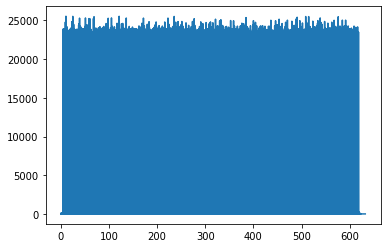

In [2]:
recording_sample_rate, recording = read(f"{path_to_dataset}/Tanda{part}.wav")
recording = np.mean(recording, axis=1)
print(recording_sample_rate)
t=np.linspace(0, len(recording)/recording_sample_rate, len(recording), False)
plt.plot(t, np.abs(recording))
plt.show()

In [3]:
audio = recording.copy()

round_duration = 0.08
pulse_duration = 0.003
bound = 10
lower_freq_1 = 0
upper_freq_1 = 4500

lower_freq_2 = 5500
upper_freq_2 = 0.5*recording_sample_rate
sample_rate=recording_sample_rate # discrete samples of the underlying function per second

# number of total signal points
N = int(round_duration*recording_sample_rate)
T = 1.0 / sample_rate
frecs = np.linspace(-1.0/(2.0*T), 1.0/(2.0*T), N) # this is after applying the shift for ploting

recordings = []
subtractions = []

where = np.argwhere(audio>audio.max()/bound)
t=np.linspace(0, round_duration, int(round_duration*recording_sample_rate), False)

last_added_j = 0


for j, where_idx in enumerate(where):
    if where_idx >= ( where[last_added_j]+int(round_duration*recording_sample_rate) ) or j==0:
        a1 = audio[ int(where_idx): int(where_idx)+int(round_duration*recording_sample_rate)]
        #fig, axs = plt.subplots(1,2, figsize=(7,3))
        #axs[0].plot(t,np.abs(a1))
        extra=0
        while np.max(a1)>2000:
            extra+=0.0001
            a1[:int((pulse_duration/3+extra)*recording_sample_rate)]=0
        subtractions.append(pulse_duration/3+extra)
        
        samplesFourierCoefs = fft(a1.astype(np.float64), N)
        samplesFourierCoefs = fftshift(samplesFourierCoefs)
        # apply filtering
        samplesFourierCoefs[ (np.abs(frecs)<=upper_freq_1) & (np.abs(frecs)>=lower_freq_1) ]=0
        samplesFourierCoefs[ (np.abs(frecs)<=upper_freq_2) & (np.abs(frecs)>=lower_freq_2) ]=0
        a1 = ifft(ifftshift(samplesFourierCoefs)).real
        #axs[1].plot(t, np.abs(a1))
        #plt.show()
        recordings.append(a1)
        #print(len(recordings))
        last_added_j=j

In [4]:
subtractions = np.array(subtractions)
np.sum((subtractions<0.002) | (subtractions>0.004))

23

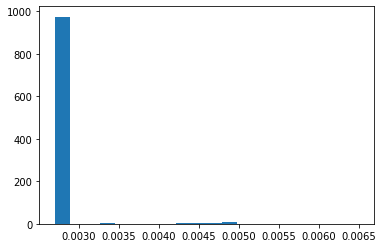

In [5]:
plt.hist(subtractions, bins=20)
plt.show()

# Save each recording wav separateley

In [6]:
depthMaps=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/FILTERED_DEPTH_MAPS/NPY/*.npy"))
for k,depth_npy_path in enumerate(depthMaps):
    np.save( f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/NPY/Echo_{depth_npy_path.split('/')[-1].split('DepthMap_')[-1]}", recordings[k])
    write(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/WAV/Echo_{depth_npy_path.split('/')[-1].split('DepthMap_')[-1].split('.npy')[0]}.wav", recording_sample_rate, recordings[k]) 

# Normalize depth maps to a common max and min and save them as png

In [3]:
depthMaps=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/FILTERED_DEPTH_MAPS/NPY/*.npy"))

max_depth = 0
min_depth = 1e9
for depth_npy_path in depthMaps:
    depth_map_unnormalized = np.load(depth_npy_path)
    if depth_map_unnormalized.max()>max_depth:
        max_depth=depth_map_unnormalized.max()
        print("max",max_depth)
    if depth_map_unnormalized.min()<min_depth:
        min_depth=depth_map_unnormalized.min()
        print("min",min_depth)    

max 2.7617197
min 0.3789624
min 0.37890628
min 0.37055758
min 0.2698519
min -0.0625
max 3.476563
max 3.5546925
max 3.6740208
max 3.8125
max 3.937502
max 3.9375021


In [4]:
for depth_npy_path in depthMaps:
    depth_map_unnormalized = np.load(depth_npy_path)
    depth_map = (255*((depth_map_unnormalized-min_depth)/max_depth)).astype(np.uint8)
    cv2.imwrite( f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/FILTERED_DEPTH_MAPS/{depth_npy_path.split('.npy')[0].split('/')[-1]}.png", depth_map)
    #plt.imshow(depth_map, cmap='gray')
    #plt.show()

# Make all audios have the same lentgh: need to check size distribution

Max audio 1833.778566854171
Max audio 1892.633268940407
Max audio 1961.766647677044
Max audio 1999.303201229022


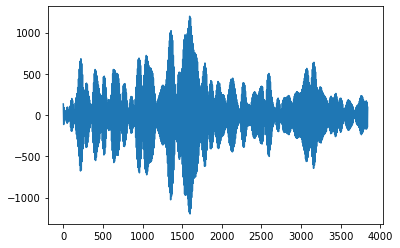

Erase?n
Maximum number of samples is 3840, minimum number of samples 3840 , average 3840.0


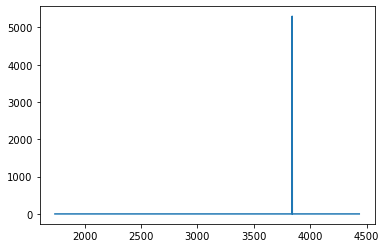

There are only 5299.0 with bigger size than 2900
There are only 0.0 with smaller than size than 2900


In [3]:
depthMaps=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/FILTERED_DEPTH_MAPS/*.png"))
audios=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/NPY/*.npy"))
wavs=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/WAV/*.wav"))
imgs = sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/USED_IMAGES/*.png"))

thresh=0.08


# lets see whcih is the maximum sound sample number to pad all the rest to this size
max_size=0
min_size=10000
av=0
max_audio=0
sizes=np.zeros((2700))
for audio_path,depth_im_path,wav_path,im_path in zip(audios, depthMaps, wavs, imgs):
    audio = np.load(audio_path)
    #audio = audio[100:]
    #audio = audio[int(np.argwhere(np.abs(audio)>np.max(np.abs(audio))*thresh)[0]):]
    if False and len(audio)<max_size:
        plt.plot(audio)
        plt.show()
        print(len(audio))
    min_size = min(min_size, len(audio))
    max_size = max(max_size, len(audio))
    av += len(audio)
    sizes[len(audio)-1736]+=1
    if np.argwhere(audio>700)[0]>700: # then they are outliers
        plt.plot(audio)
        plt.show()
        er=input("Erase?")
        if er=="y":
            print("erased!")
            os.remove(depth_im_path)
            os.remove(audio_path)
            os.remove(wav_path)
            os.remove(im_path)
    if max_audio<np.abs(audio).max():
        max_audio = np.abs(audio).max()
        print("Max audio", max_audio)

print(f"Maximum number of samples is {max_size}, minimum number of samples {min_size} , average {av/len(audios)}")
plt.plot(np.arange(2700)+1736, sizes)
plt.show()
print(f"There are only {np.sum(sizes[(3740-1736):])} with bigger size than 2900")
print(f"There are only {np.sum(sizes[:(3700-1736)])} with smaller than size than 2900")

# Generate dataset!

In [3]:
depthMaps=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/FILTERED_DEPTH_MAPS/*.png"))
audios=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/NPY/*.npy"))
wavs=sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/SOUND_RECORDINGS/WAV/*.wav"))
imgs = sorted(glob.glob(f"{path_to_dataset}/SOUND_ECHO_and_DEPTH{part}/DEPTH_MAPS/USED_IMAGES/*.png"))

reduce_audio_length_by = 2
reduce_h_w_image_by = 8

size_audio=3840
max_audio=2000

In [4]:
h5f = h5py.File(f"{path_to_dataset}/Dataset_downscaled_audio.h5", 'a') # append if exists, create if not


for idx, (audio_path, image_path) in enumerate(zip(audios, depthMaps)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # take audio part from the point where stuff begins
    audio = np.load(audio_path)
    #audio = audio[100:]
    #audio = audio[int(np.argwhere(np.abs(audio)>np.max(np.abs(audio))*thresh)[0]):]
    
    # first pad audio to correct size
    if len(audio)>size_audio:
        audio = audio[:size_audio]
    if len(audio)<size_audio:
        audio = np.pad( audio, (0, size_audio-len(audio)))
        
    if reduce_audio_length_by !=1:
        audio = downscale_local_mean( audio, (reduce_audio_length_by,))
        audio = downscale_local_mean( np.abs(audio), (3,))

    if reduce_h_w_image_by!=1:
        image = downscale_local_mean( image, (reduce_h_w_image_by, reduce_h_w_image_by))
    
    h5f.create_dataset(f"{idx}_aud", data=np.abs(audio.astype(np.float32))/max_audio, compression="lzf", shuffle=True) 
    h5f.create_dataset(f"{idx}_im", data=image.astype(np.float32)/255, compression="lzf", shuffle=True) 
    if idx%500==0:
        print(idx)

h5f.flush()
h5f.close()

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000


In [5]:
h5f = h5py.File(f"{path_to_dataset}/Dataset_downscaled_audio.h5", 'r')

In [6]:
len(h5f)/2

5299.0

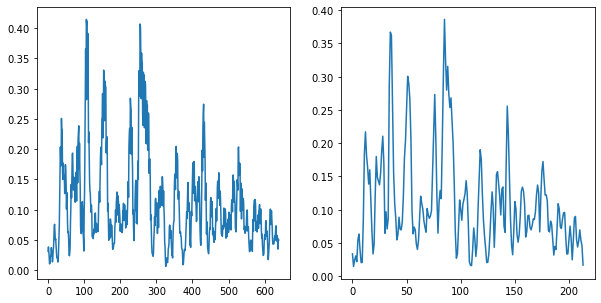

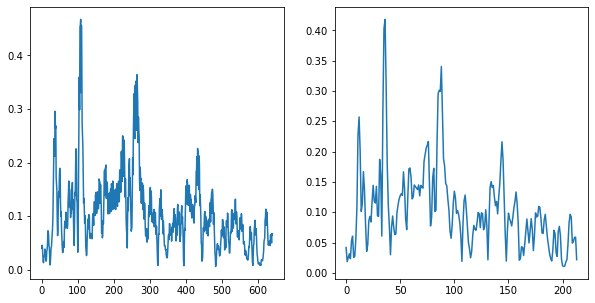

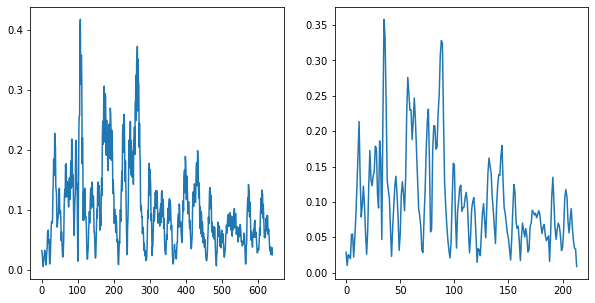

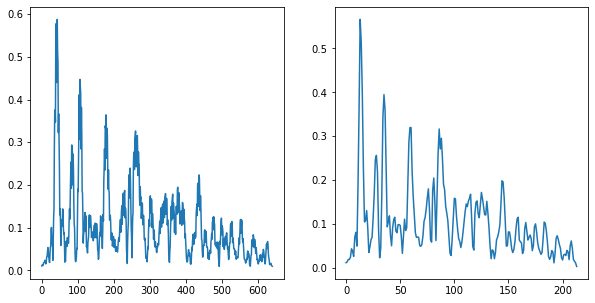

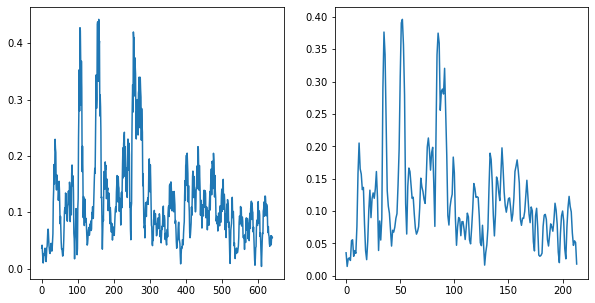

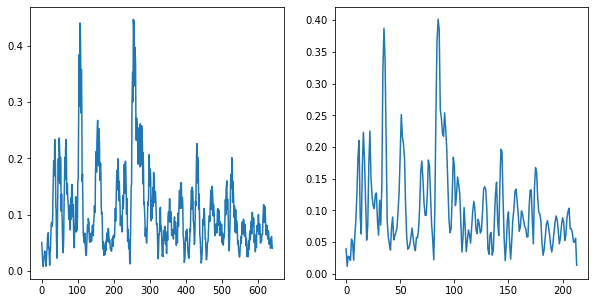

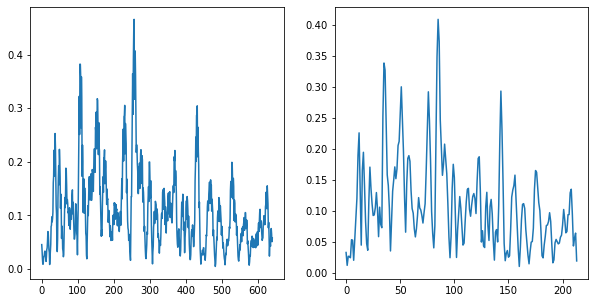

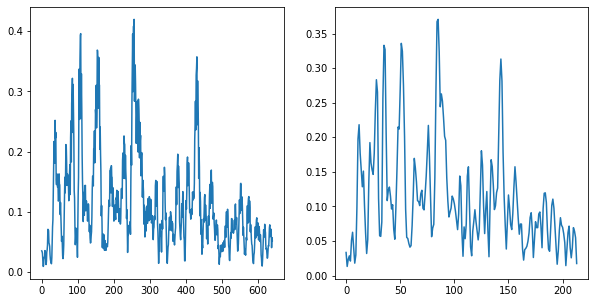

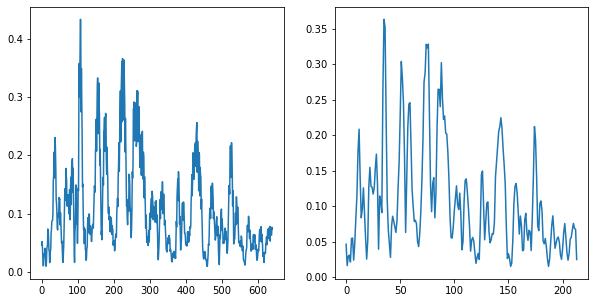

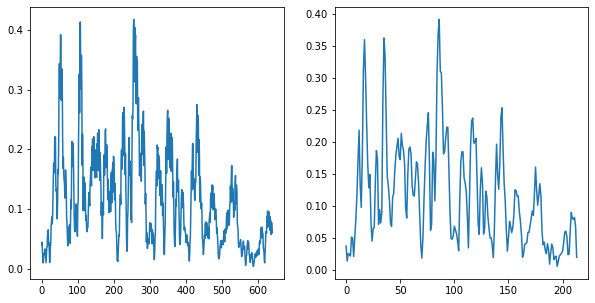

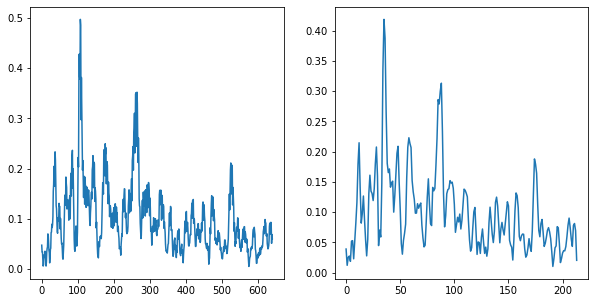

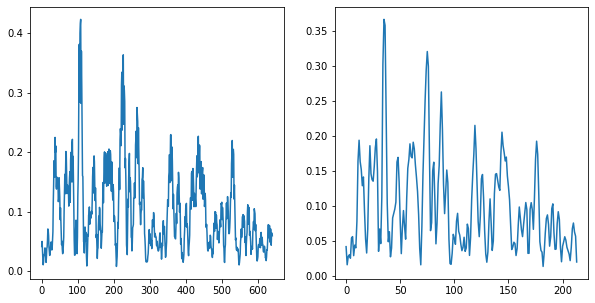

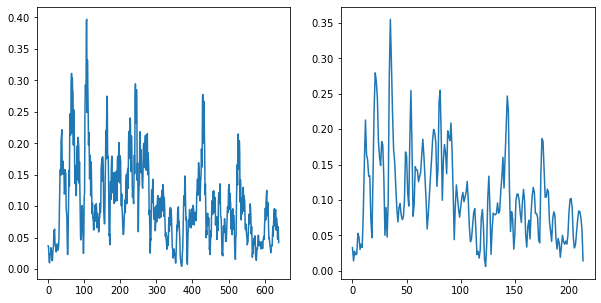

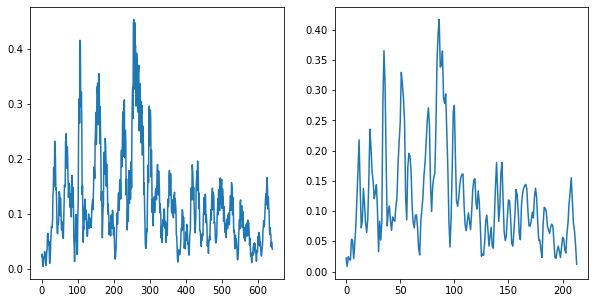

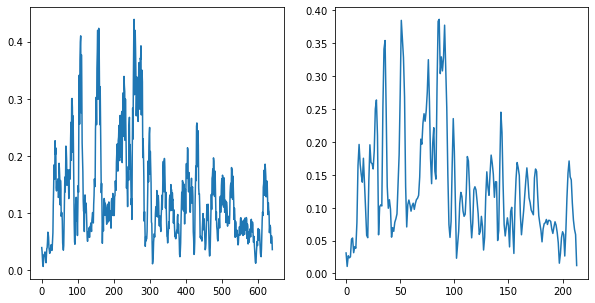

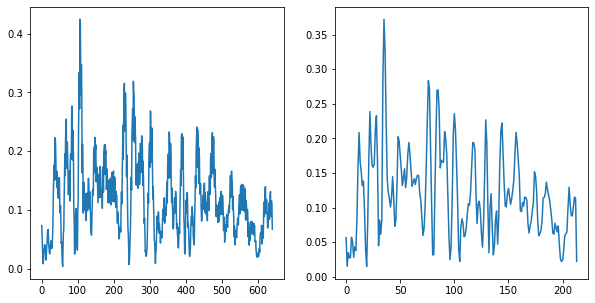

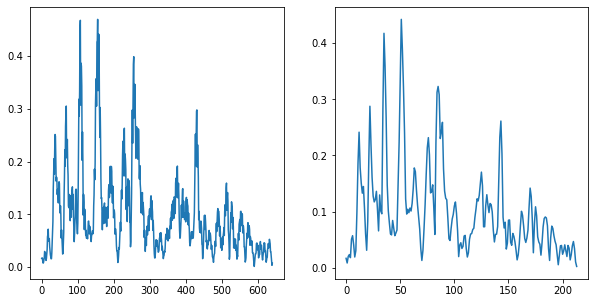

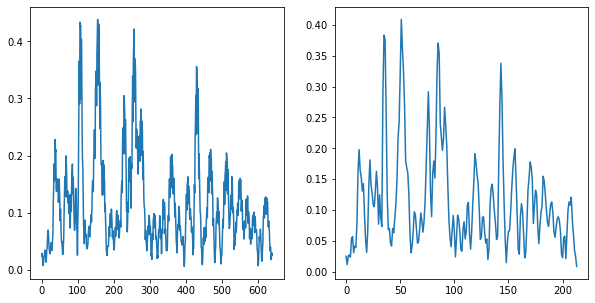

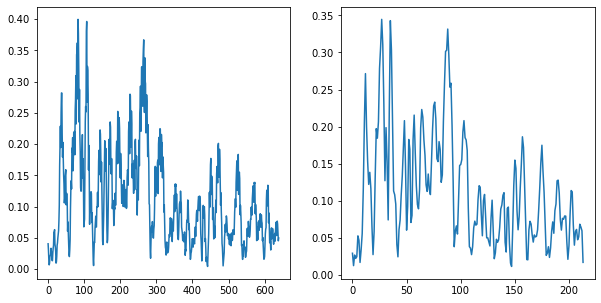

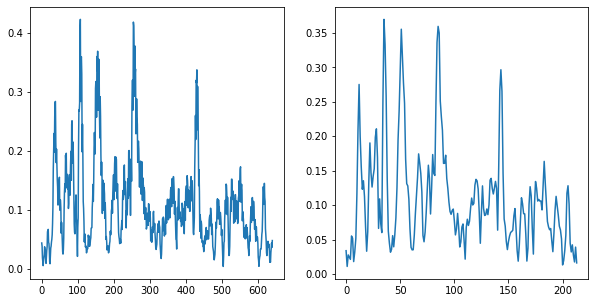

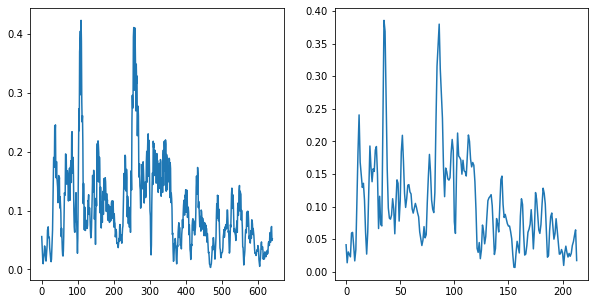

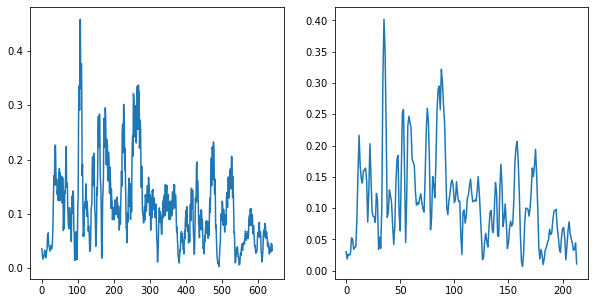

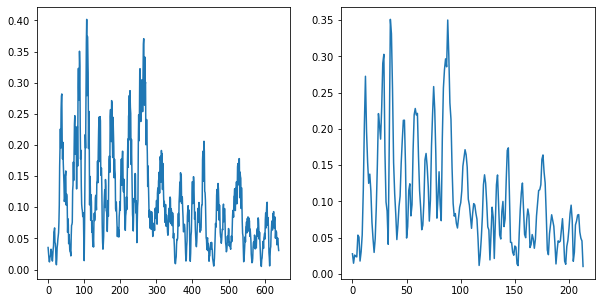

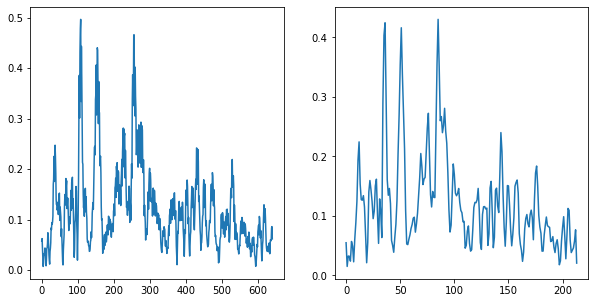

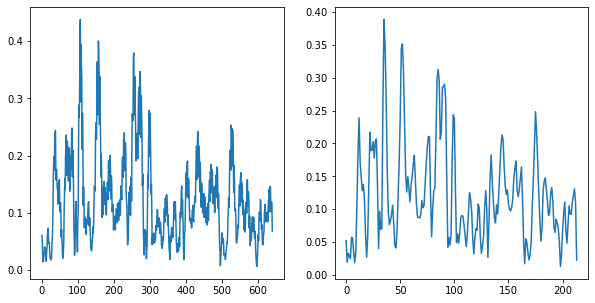

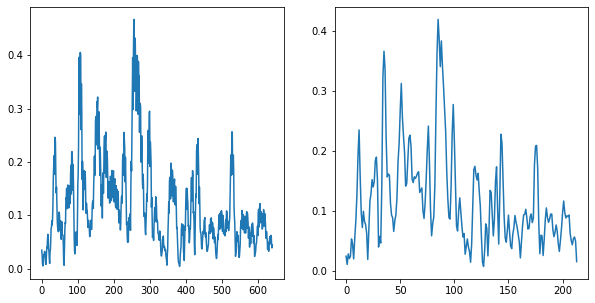

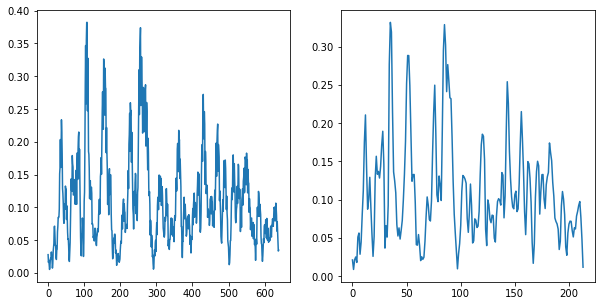

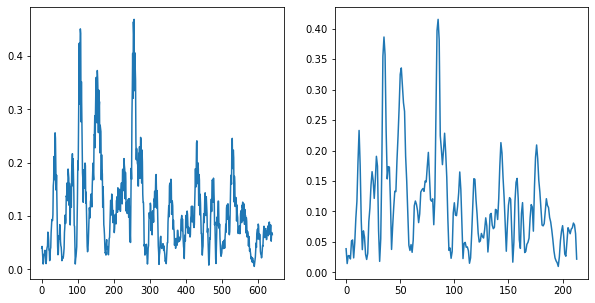

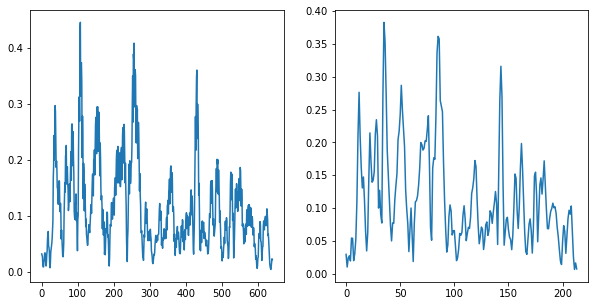

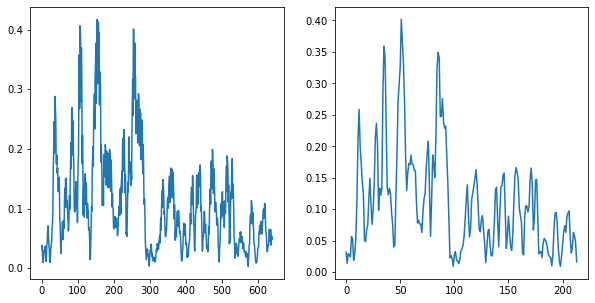

In [7]:
from scipy.signal import hilbert
for i in np.random.randint(0, len(h5f)/2, 30):
    audio = np.array(h5f[f"{i}_aud"])
    fig, axs = plt.subplots(1,2, figsize=(10,5))

    axs[0].plot(audio)
    audio = downscale_local_mean( audio, (3,))
    #analytic_signal = hilbert(audio)
    #amplitude_envelope = np.abs(analytic_signal)
    axs[1].plot(audio)
    #axs[1].plot(amplitude_envelope)
    plt.show()

In [ ]:
for i in np.random.randint(0, len(h5f)/2, 30):
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    axs[0].imshow(h5f[f"{i}_im"], cmap='gray')
    axs[1].plot(np.array(h5f[f"{i}_aud"]))
    plt.show()

In [8]:
h5f.close()

In [52]:
h5f = h5py.File(f"{path_to_dataset}/Dataset.h5", 'r')

In [53]:
for i in range(10):
    print(h5f[f"{i}_im"].shape)

(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)
(57, 68)


In [54]:
h5f.close()